#### Imports

In [186]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mlp
import seaborn as sns
import pandas as pd
from tqdm import tqdm

In [187]:
%matplotlib inline

#### Tool functions

In [188]:
def pplot(T_vec, N = 4, start = 0, step = 1, setLimits = []):
    nlines = N//2
    fig, axs = plt.subplots(nlines, 2, figsize = (10, 4*nlines))
    fig.tight_layout(pad = 5)

    num_ticks = 11
    # number of points in x and y
    nx = len(Xv)
    ny = len(Yv)
    # the index of the position of yticks
    yticks = np.linspace(0, len(Yv) - 1, num_ticks, dtype=int)
    xticks = np.linspace(0, len(Xv) - 1, num_ticks, dtype=int)

    fmtx = lambda x, pos: '{:.2f}'.format(x*Lx/nx, pos)
    fmty = lambda y, pos: '{:.2f}'.format(y*Ly/ny, pos)

    for i in range(N):
        idxLine = i//2
        idxCol = i % 2

        idx = start + step*i

        T = np.reshape(T_vec[idx], (Nx, Ny))
        
        if len(setLimits) == 0:
            minV = min(T_vec[idx])
            maxV = max(T_vec[idx])
        else:
            minV = setLimits[0]
            maxV = setLimits[1]

        sns.heatmap(
        T,
        ax = axs[idxLine, idxCol],
        cmap = "Spectral_r",
        vmin = minV,
        vmax = maxV 
        )

        axs[idxLine, idxCol].invert_yaxis()
        axs[idxLine, idxCol].set_xticks(xticks)
        axs[idxLine, idxCol].set_yticks(yticks)

        axs[idxLine, idxCol].set(xlabel = r'$x^*$', ylabel = r'$y^*$')
        axs[idxLine, idxCol].set_title('t = %.3e' % ((idx)*dt))
        axs[idxLine, idxCol].xaxis.set_major_formatter(mlp.ticker.FuncFormatter(fmtx))
        axs[idxLine, idxCol].yaxis.set_major_formatter(mlp.ticker.FuncFormatter(fmty))
    
    plt.show()

#### Implicit Method: Manufactured Solution

Definition of the A matrix

In [258]:
# Geometry on X
Lx = 1
Nx = 100
dx = Lx/(Nx - 1)

# Geometry on Y
Ly = 1
Ny = 100
dy = Ly/(Ny - 1)

Npoints = Nx*Ny

# Mesh
Xv = np.linspace(0, Lx, Nx)
Yv = np.linspace(0, Ly, Ny)
X, Y = np.meshgrid(Xv, Yv)

X = np.reshape(X, Npoints)
Y = np.reshape(Y, Npoints)

# Time
dt = 0.001
Nt = 10_000
Time = np.arange(0, Nt*dt, dt)

# Material is Cordierite 
k = 1    #W/(m*K)
cv = 1   #J/(kg*C)
rho = 1 #kg/m3
# k = 2.5    #W/(m*K)
# cv = 900   #J/(kg*C)
# rho = 2300 #kg/m3

alpha = k/(rho*cv)

In [190]:
# Definition of the Boundary Conditions points
bc_bottom = np.arange(0, Nx, 1)
bc_left   = np.arange(Nx, Npoints - Nx, Nx)
bc_top    = bc_bottom + Npoints - Nx
bc_right  = bc_left + Nx - 1

bc = np.hstack([bc_bottom, bc_left, bc_top, bc_right])
core = np.hstack([np.arange(Nx + 1, 2*Nx - 1, 1) + Nx*j for j in range(0,Ny - 2)])

In [191]:
T_manu = lambda i, j:  (X[j]**2 + Y[j]**2)*np.exp(-Time[i])
Q_manu = lambda i, j: -(X[j]**2 + Y[j]**2 + 4*alpha)*rho*cv*np.exp(-Time[i])

In [192]:
T_bc = np.array([[T_manu(i, j) for j in bc] for i in np.arange(0, Nt, 1)])

In [193]:
A = np.eye(Npoints)
b = np.zeros(Npoints, dtype= 'float64')

for i in core:
    A[i,      i] = 1 + 2*alpha*dt*(1/dx**2 + 1/dy**2)
    A[i,  i - 1] = -alpha*dt/dy**2
    A[i,  i + 1] = -alpha*dt/dy**2
    A[i, i - Nx] = -alpha*dt/dx**2
    A[i, i + Nx] = -alpha*dt/dx**2

for i, idx in enumerate(bc):
    b[idx] = T_bc[0][i]

for i, idx in enumerate(core):
    b[idx] = Q_manu(0, i)*dt/(rho*cv)

In [194]:
T_vec = np.zeros((Nt, Npoints))

In [195]:
# Initializing Temperature
for idx in range(Npoints):
    T_vec[0, idx] = T_manu(0, idx)

In [196]:
Ainv = np.linalg.inv(A)

In [197]:
for k in tqdm(range(1, Nt)):
    for i, idx in enumerate(bc):
        b[idx] = T_manu(k, idx) - T_manu(k - 1, idx)

    for i, idx in enumerate(core):
        b[idx] = Q_manu(k, idx)*dt/(rho*cv)

    T_vec[k] = Ainv@(T_vec[k - 1] + b)

100%|██████████| 9999/9999 [08:13<00:00, 20.25it/s]


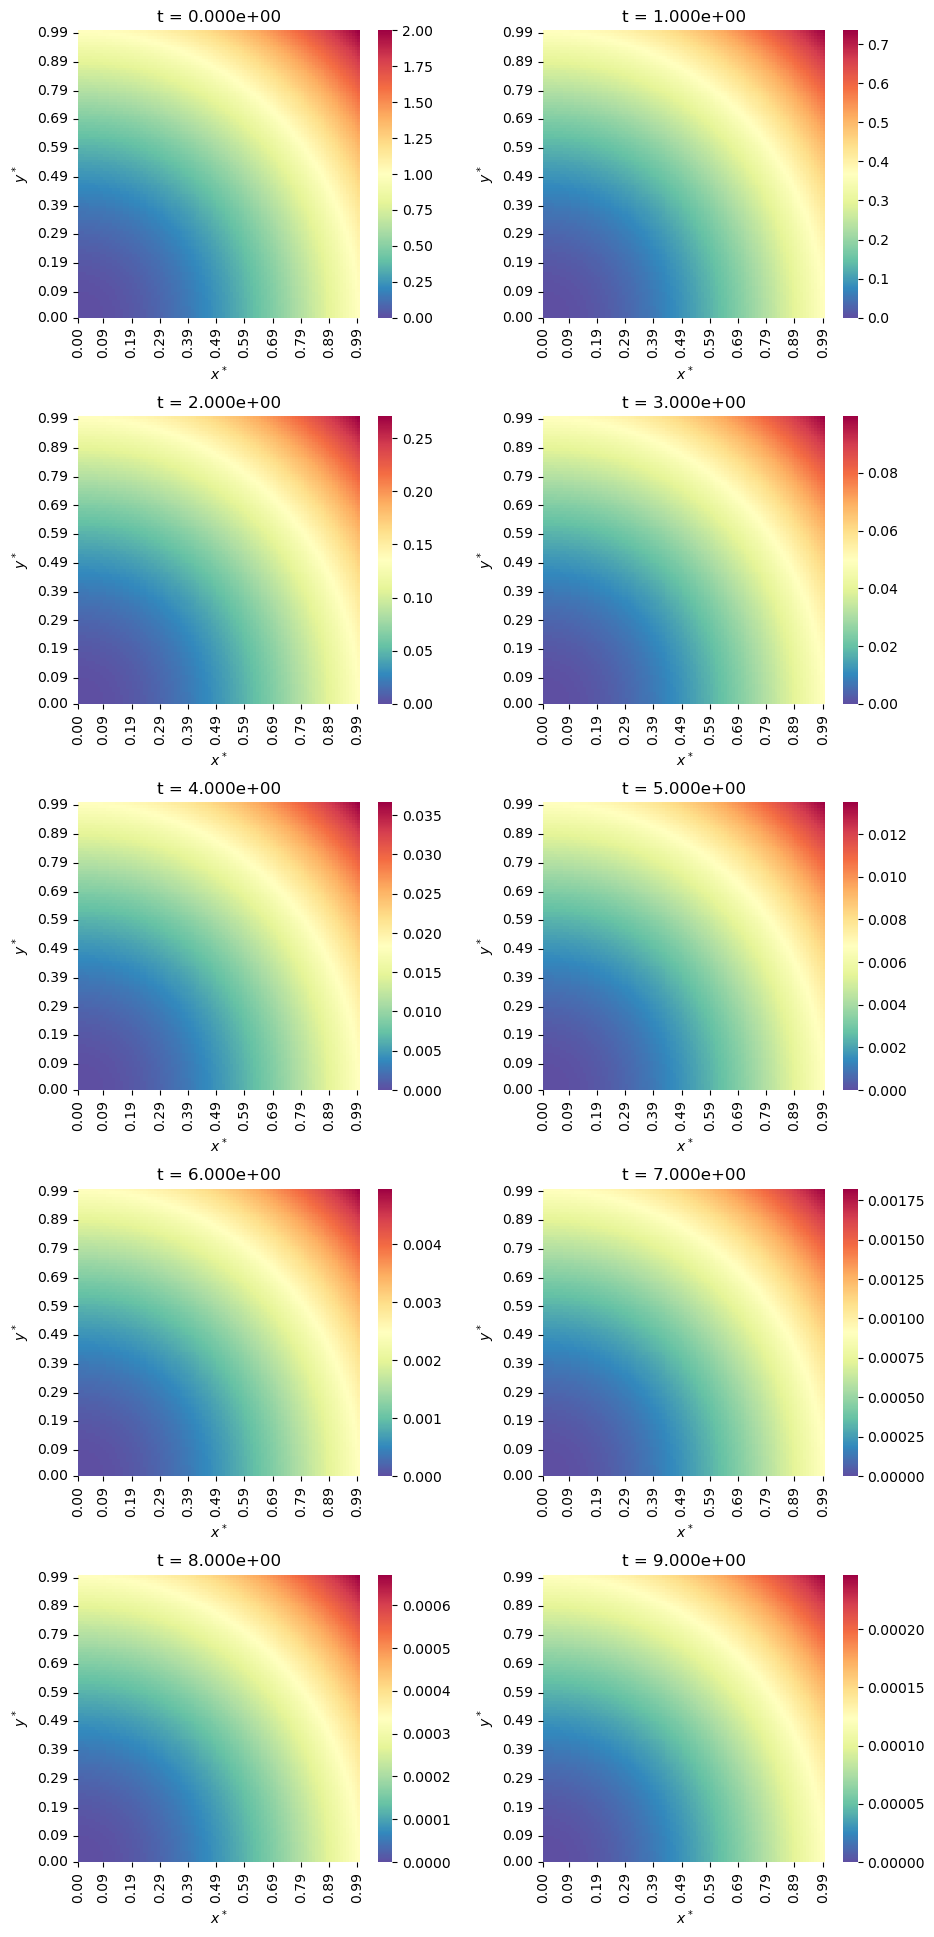

In [209]:
pplot(T_vec, N = 10, step = Nt//10)

/var/folders/xc/tffvs1z54w7bwv3cb731l0dc0000gn/T/ipykernel_2071/3644001514.py:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(pad = 4)


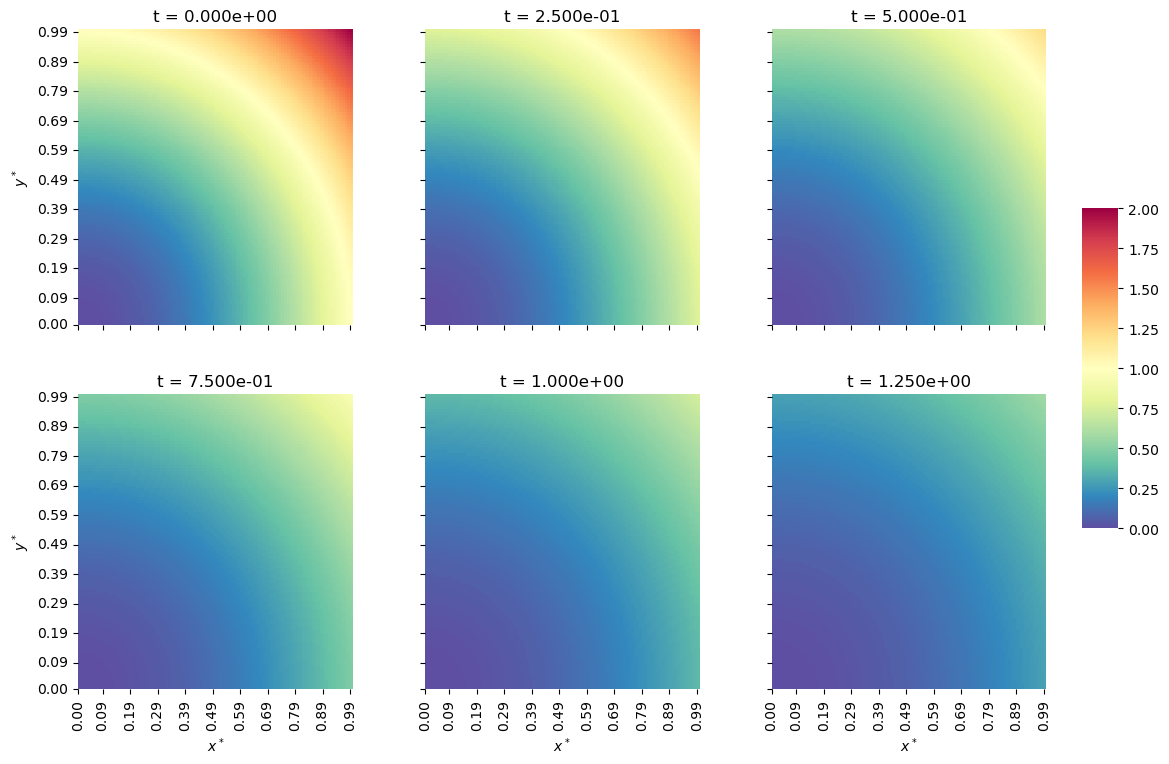

In [212]:
N = 6
start = 0
step = 250
setLimits = [0, 2]

nlines = N // 3
fig, axs = plt.subplots(nlines, 3, figsize = (12, 4*nlines), sharex = True, sharey = True)
fig.tight_layout(pad = 5)

num_ticks = 11
# number of points in x and y
nx = len(Xv)
ny = len(Yv)
# the index of the position of yticks
yticks = np.linspace(0, len(Yv) - 1, num_ticks, dtype=int)
xticks = np.linspace(0, len(Xv) - 1, num_ticks, dtype=int)

fmtx = lambda x, pos: '{:.2f}'.format(x*Lx/nx, pos)
fmty = lambda y, pos: '{:.2f}'.format(y*Ly/ny, pos)
    
cbar_ax = fig.add_axes([.91, .3, .03, .4])

fig.tight_layout(pad = 4)
plt.subplots_adjust(right = 0.88)

for i in range(N):
    idxLine = i//3
    idxCol = i % 3

    idx = start + step*i

    T = np.reshape(T_vec[idx], (Nx, Ny))
    
    if len(setLimits) == 0:
        minV = min(T_vec[idx])
        maxV = max(T_vec[idx])
    else:
        minV = setLimits[0]
        maxV = setLimits[1]


    sns.heatmap(
    T,
    ax = axs[idxLine, idxCol],
    cmap = "Spectral_r",
    vmin = minV,
    vmax = maxV,
    cbar_ax= cbar_ax
    )

    axs[idxLine, idxCol].invert_yaxis()
    axs[idxLine, idxCol].set_xticks(xticks)
    axs[idxLine, idxCol].set_yticks(yticks)

    if idxLine == nlines - 1: axs[idxLine, idxCol].set(xlabel = r'$x^*$')
    if idxCol  == 0: axs[idxLine, idxCol].set(ylabel = r'$y^*$')
    axs[idxLine, idxCol].set_title('t = %.3e' % ((idx)*dt))
    axs[idxLine, idxCol].xaxis.set_major_formatter(mlp.ticker.FuncFormatter(fmtx))
    axs[idxLine, idxCol].yaxis.set_major_formatter(mlp.ticker.FuncFormatter(fmty))

plt.show()

In [215]:
Manu_solution_vec = np.array([[T_manu(i,j)for j in range(Npoints)] for i in range(Nt)])

In [216]:
Error_vec = abs(T_vec - Manu_solution_vec)

SRME = np.sqrt(sum(sum(Error_vec**2))/(Nt*Npoints))
MAE = sum(sum(Error_vec))/(Nt*Npoints)
Max  = max(np.reshape(Error_vec, (Nt*Npoints)))

In [217]:
print('O erro quadrático médio é: %.3e' % (SRME))
print('O erro absoluto médio é: %.3e' % (MAE))
print('O erro máximo é: %.3e' % (Max))

O erro quadrático médio é: 2.737e-06
O erro absoluto médio é: 1.041e-06
O erro máximo é: 2.012e-05


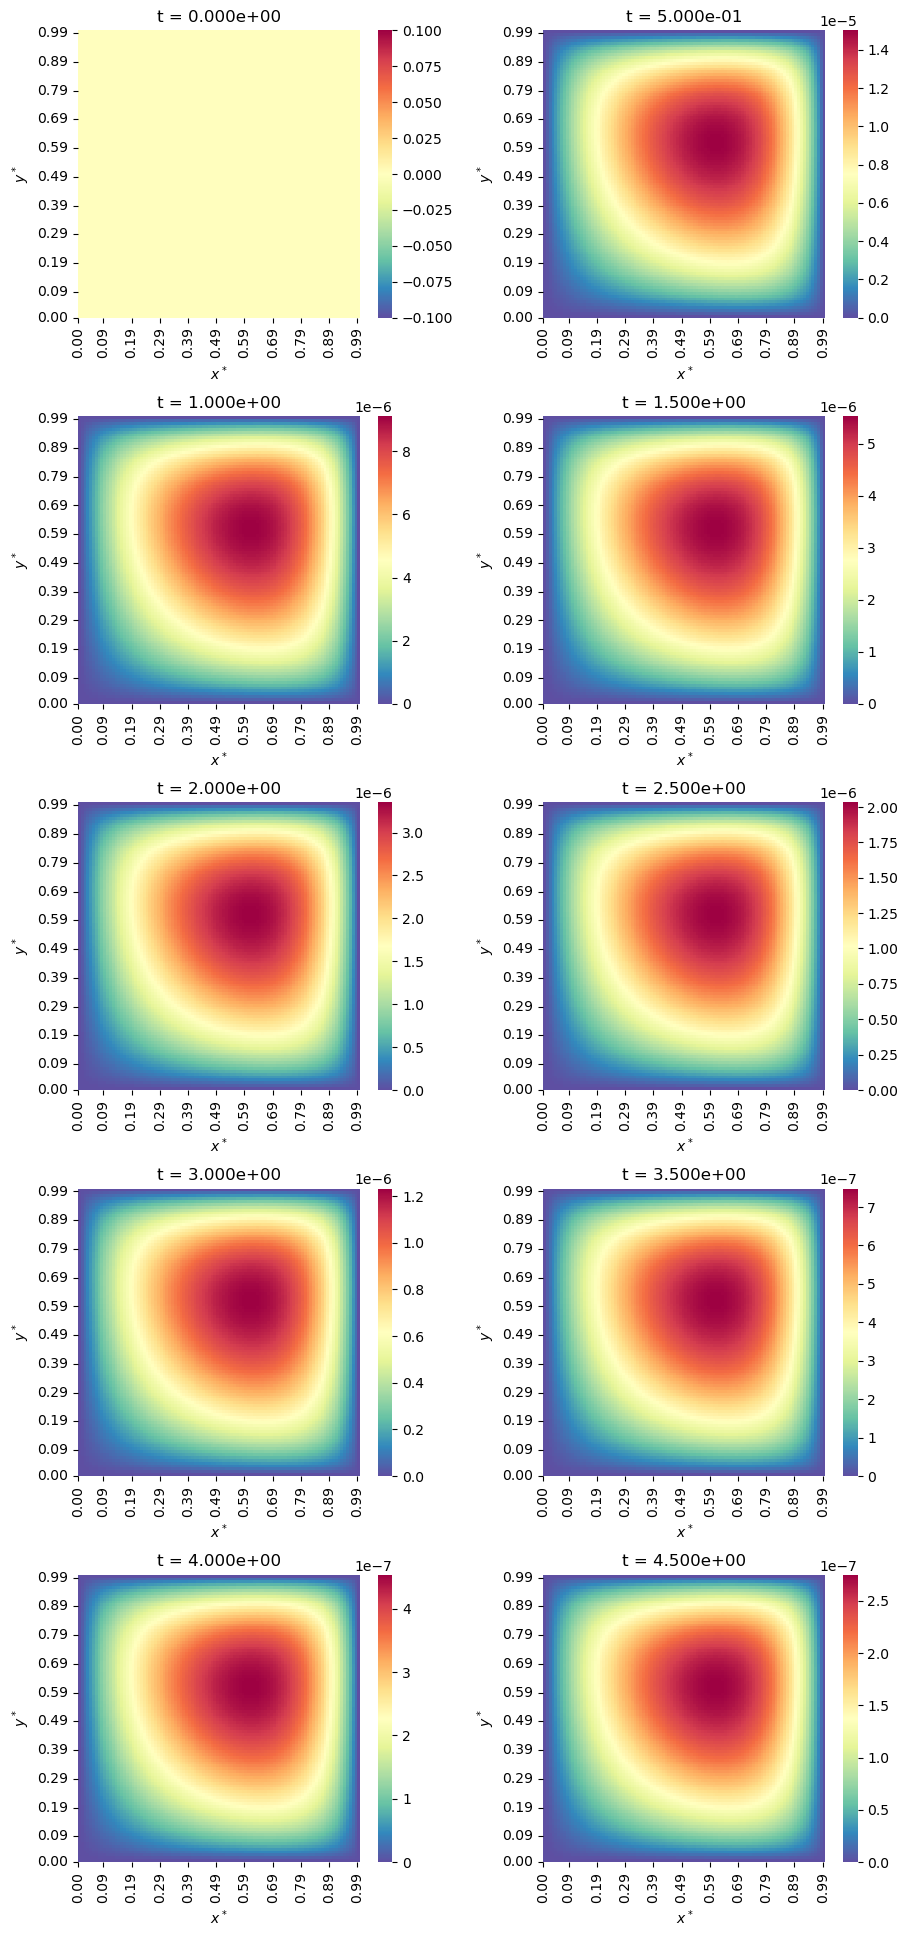

In [218]:
pplot(Error_vec, N = 10, step = 500, setLimits = [])

/var/folders/xc/tffvs1z54w7bwv3cb731l0dc0000gn/T/ipykernel_2071/953849576.py:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(pad = 4)


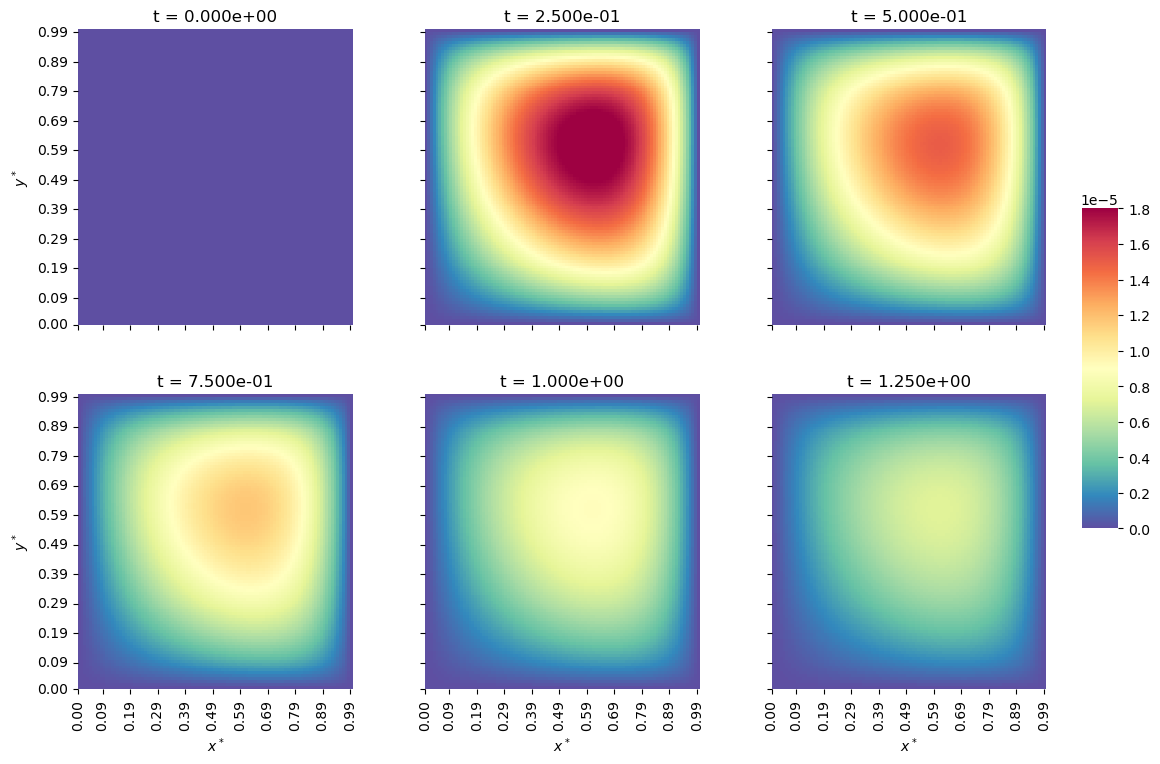

In [230]:
N = 6
start = 0
step = 250
setLimits = [0, 1.8e-5]

nlines = N // 3
fig, axs = plt.subplots(nlines, 3, figsize = (12, 4*nlines), sharex = True, sharey = True)
fig.tight_layout(pad = 5)

num_ticks = 11
# number of points in x and y
nx = len(Xv)
ny = len(Yv)
# the index of the position of yticks
yticks = np.linspace(0, len(Yv) - 1, num_ticks, dtype=int)
xticks = np.linspace(0, len(Xv) - 1, num_ticks, dtype=int)

fmtx = lambda x, pos: '{:.2f}'.format(x*Lx/nx, pos)
fmty = lambda y, pos: '{:.2f}'.format(y*Ly/ny, pos)
    
cbar_ax = fig.add_axes([.91, .3, .03, .4])

fig.tight_layout(pad = 4)
plt.subplots_adjust(right = 0.88)

for i in range(N):
    idxLine = i//3
    idxCol = i % 3

    idx = start + step*i

    T = np.reshape(Error_vec[idx], (Nx, Ny))
    
    if len(setLimits) == 0:
        minV = min(T_vec[idx])
        maxV = max(T_vec[idx])
    else:
        minV = setLimits[0]
        maxV = setLimits[1]


    sns.heatmap(
    T,
    ax = axs[idxLine, idxCol],
    cmap = "Spectral_r",
    vmin = minV,
    vmax = maxV,
    cbar_ax= cbar_ax
    )

    axs[idxLine, idxCol].invert_yaxis()
    axs[idxLine, idxCol].set_xticks(xticks)
    axs[idxLine, idxCol].set_yticks(yticks)

    if idxLine == nlines - 1: axs[idxLine, idxCol].set(xlabel = r'$x^*$')
    if idxCol  == 0: axs[idxLine, idxCol].set(ylabel = r'$y^*$')
    axs[idxLine, idxCol].set_title('t = %.3e' % ((idx)*dt))
    axs[idxLine, idxCol].xaxis.set_major_formatter(mlp.ticker.FuncFormatter(fmtx))
    axs[idxLine, idxCol].yaxis.set_major_formatter(mlp.ticker.FuncFormatter(fmty))

plt.show()

In [231]:
srme_error_vec = [np.sqrt(sum(Error_vec[i]**2)/Npoints) for i in range(Nt)] 

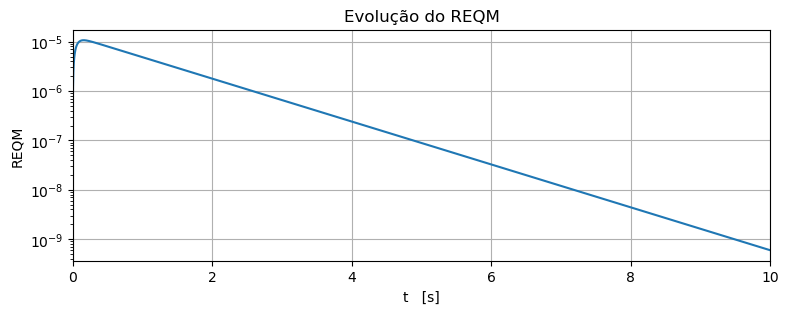

In [259]:
plt.figure(figsize = (9, 3))

plt.plot((Time)[1:], srme_error_vec[1:])
plt.xlim(left = 0, right = 10)
plt.yscale('log')
plt.title('Evolução do REQM')
plt.xlabel('t   [s]')
plt.ylabel('REQM')
plt.grid()

plt.show()

#### Numerical Solution: Wolfram Mathematica

In [260]:
# Geometry on X
Lx = 1
Nx = 101
dx = Lx/(Nx - 1)

# Geometry on Y
Ly = 1
Ny = 101
dy = Ly/(Ny - 1)

Npoints = Nx*Ny

# Mesh
Xv = np.linspace(0, Lx, Nx)
Yv = np.linspace(0, Ly, Ny)
X, Y = np.meshgrid(Xv, Yv)

X = np.reshape(X, Npoints)
Y = np.reshape(Y, Npoints)

# Time
Lt = 0.1
Nt = 101
Time = np.linspace(0, Lt, Nt)
dt = Time[1] - Time[0]

In [261]:
ratio = (Nx - 1)//50

In [262]:
# Definition of the Boundary Conditions points
bc_bottom = np.arange(0, Nx, 1)
bc_left   = np.arange(Nx, Npoints - Nx, Nx)
bc_top    = bc_bottom + Npoints - Nx
bc_right  = bc_left + Nx - 1

bc = np.hstack([bc_bottom, bc_left, bc_top, bc_right])
core = np.hstack([np.arange(Nx + 1, 2*Nx - 1, 1) + Nx*j for j in range(0,Ny - 2)])

In [263]:
Q = 100*rho*cv

In [264]:
A = np.eye(Npoints)
b = np.zeros(Npoints, dtype= 'float64')

for i in core:
    A[i,      i] = 1 + 2*alpha*dt*(1/dx**2 + 1/dy**2)
    A[i,  i - 1] = -alpha*dt/dy**2
    A[i,  i + 1] = -alpha*dt/dy**2
    A[i, i - Nx] = -alpha*dt/dx**2
    A[i, i + Nx] = -alpha*dt/dx**2

    b[i] = Q*dt/(rho*cv)

In [265]:
T_num_vec = np.zeros((Nt, Npoints))

In [266]:
Ainv = np.linalg.inv(A)

In [267]:
for k in tqdm(range(1, Nt)):
    T_num_vec[k] = Ainv@(T_num_vec[k - 1] + b)

100%|██████████| 100/100 [00:02<00:00, 45.34it/s]


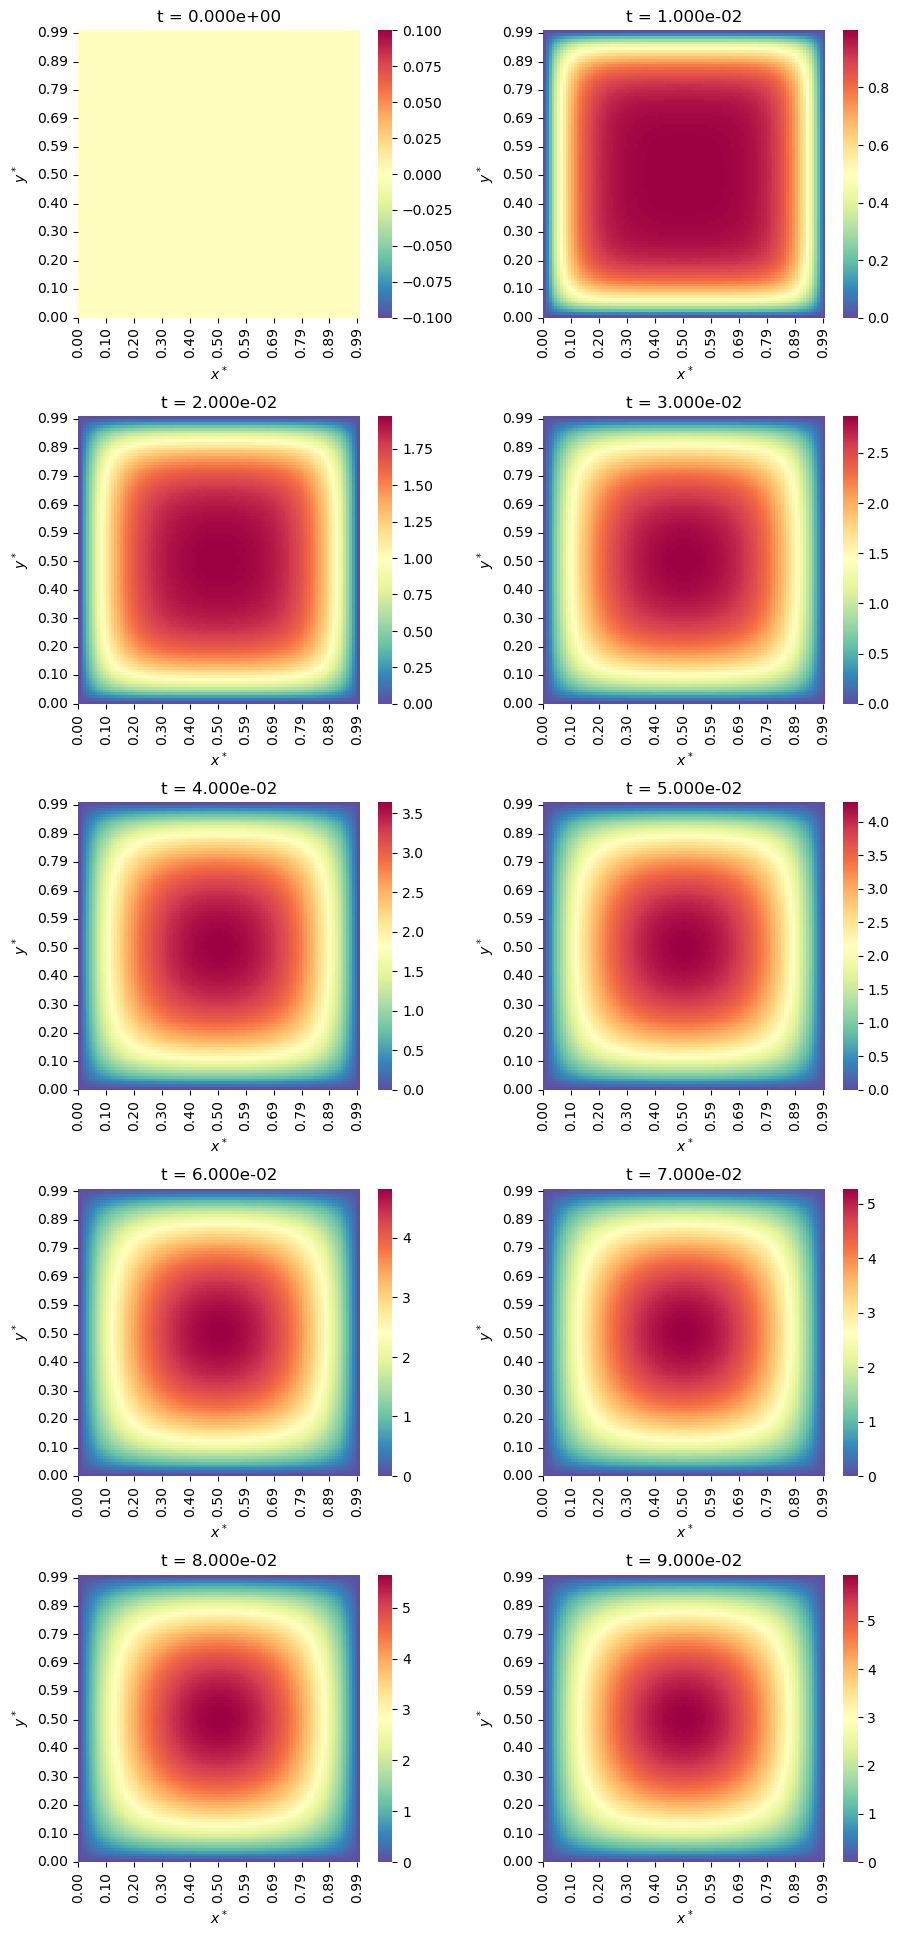

In [268]:
pplot(T_num_vec, N = 10, start = 0, step = 10, setLimits = [])

/var/folders/xc/tffvs1z54w7bwv3cb731l0dc0000gn/T/ipykernel_2071/2801577968.py:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(pad = 5)


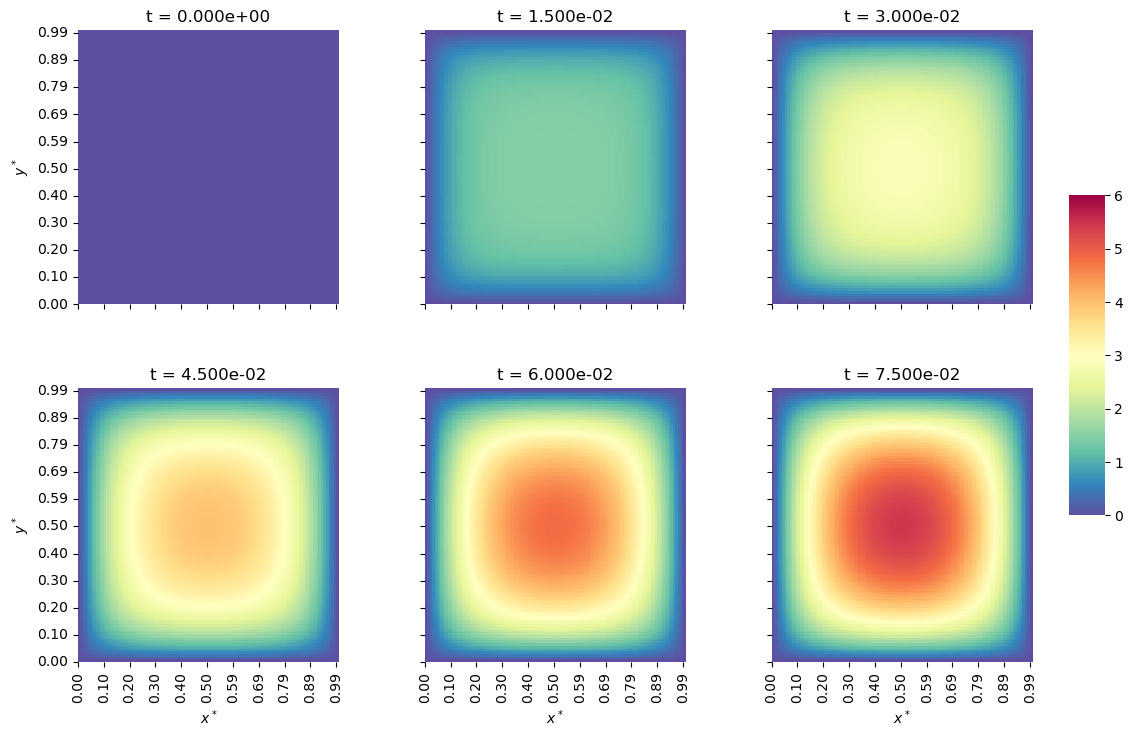

In [269]:
N = 6
start = 0
step = 15
setLimits = [0, 6]

nlines = N // 3
fig, axs = plt.subplots(nlines, 3, figsize = (12, 4*nlines), sharex = True, sharey = True)
fig.tight_layout(pad = 5)

num_ticks = 11
# number of points in x and y
nx = len(Xv)
ny = len(Yv)
# the index of the position of yticks
yticks = np.linspace(0, len(Yv) - 1, num_ticks, dtype=int)
xticks = np.linspace(0, len(Xv) - 1, num_ticks, dtype=int)

fmtx = lambda x, pos: '{:.2f}'.format(x*Lx/nx, pos)
fmty = lambda y, pos: '{:.2f}'.format(y*Ly/ny, pos)
    
cbar_ax = fig.add_axes([.91, .3, .03, .4])

fig.tight_layout(pad = 5)
plt.subplots_adjust(right = 0.88)

for i in range(N):
    idxLine = i//3
    idxCol = i % 3

    idx = start + step*i

    T = np.reshape(T_num_vec[idx], (Nx, Ny))
    
    if len(setLimits) == 0:
        minV = min(T_vec[idx])
        maxV = max(T_vec[idx])
    else:
        minV = setLimits[0]
        maxV = setLimits[1]


    sns.heatmap(
    T,
    ax = axs[idxLine, idxCol],
    cmap = "Spectral_r",
    vmin = minV,
    vmax = maxV,
    cbar_ax= cbar_ax
    )

    axs[idxLine, idxCol].invert_yaxis()
    axs[idxLine, idxCol].set_xticks(xticks)
    axs[idxLine, idxCol].set_yticks(yticks)

    if idxLine == nlines - 1: axs[idxLine, idxCol].set(xlabel = r'$x^*$')
    if idxCol  == 0: axs[idxLine, idxCol].set(ylabel = r'$y^*$')
    axs[idxLine, idxCol].set_title('t = %.3e' % ((idx)*dt))
    axs[idxLine, idxCol].xaxis.set_major_formatter(mlp.ticker.FuncFormatter(fmtx))
    axs[idxLine, idxCol].yaxis.set_major_formatter(mlp.ticker.FuncFormatter(fmty))

plt.show()

In [270]:
num_solution = pd.read_csv('transcal_num_solution_indexed.csv',
                            sep=',', 
                            names=["idx_x", "x", "idx_y", "y", "idx_t", "t", "f(x, y, t)"])

num_solution['idx_x'] = num_solution['idx_x'] - 1
num_solution['idx_y'] = num_solution['idx_y'] - 1
num_solution['idx_t'] = num_solution['idx_t'] - 1

num_solution['t'] = (num_solution['t']*1000)//1/1000

num_solution['idx_xy'] = num_solution['idx_x'] + 51*num_solution['idx_y']

num_solution['calculated f'] = T_num_vec[num_solution['idx_t']*ratio, num_solution['idx_x']*ratio + Nx*num_solution['idx_y']*ratio]
num_solution['error'] = abs(num_solution['calculated f'] - num_solution['f(x, y, t)'] )

In [271]:
num_solution.head(25)

,idx_x,x,idx_y,y,idx_t,t,"f(x, y, t)",idx_xy,calculated f,error
0,0,0.0,0,0.0,0,0.000,0.0,0,0.0,0.0
1,0,0.0,0,0.0,1,0.002,0.0,0,0.0,0.0
2,0,0.0,0,0.0,2,0.004,0.0,0,0.0,0.0
3,0,0.0,0,0.0,3,0.006,0.0,0,0.0,0.0
4,0,0.0,0,0.0,4,0.008,0.0,0,0.0,0.0
5,0,0.0,0,0.0,5,0.010,0.0,0,0.0,0.0
6,0,0.0,0,0.0,6,0.012,0.0,0,0.0,0.0
7,0,0.0,0,0.0,7,0.014,0.0,0,0.0,0.0
8,0,0.0,0,0.0,8,0.016,0.0,0,0.0,0.0
9,0,0.0,0,0.0,9,0.018,0.0,0,0.0,0.0


In [272]:
num_solution['t'].describe()

count    132651.000000
mean          0.049980
std           0.029434
min           0.000000
25%           0.024000
50%           0.050000
75%           0.076000
max           0.100000
Name: t, dtype: float64

In [273]:
SRME = np.sqrt(sum(num_solution['error']**2)/(Nt*Npoints))
MAE = sum(num_solution['error'])/(Nt*Npoints)
Max  = max(num_solution['error'])

In [274]:
print('O erro quadrático médio é: %.3e' % (SRME))
print('O erro absoluto médio é: %.3e' % (MAE))
print('O erro máximo é: %.3e' % (Max))

O erro quadrático médio é: 4.631e-03
O erro absoluto médio é: 1.335e-03
O erro máximo é: 2.914e-02


In [275]:
error_list = []

for i in range((Nt + 1)//2):
    error_list.append(sum((num_solution[num_solution['idx_t'] == i]['error']**2))/len(num_solution[num_solution['idx_t'] == i]))

In [279]:
Time[::2]

array([0.   , 0.002, 0.004, 0.006, 0.008, 0.01 , 0.012, 0.014, 0.016,
       0.018, 0.02 , 0.022, 0.024, 0.026, 0.028, 0.03 , 0.032, 0.034,
       0.036, 0.038, 0.04 , 0.042, 0.044, 0.046, 0.048, 0.05 , 0.052,
       0.054, 0.056, 0.058, 0.06 , 0.062, 0.064, 0.066, 0.068, 0.07 ,
       0.072, 0.074, 0.076, 0.078, 0.08 , 0.082, 0.084, 0.086, 0.088,
       0.09 , 0.092, 0.094, 0.096, 0.098, 0.1  ])

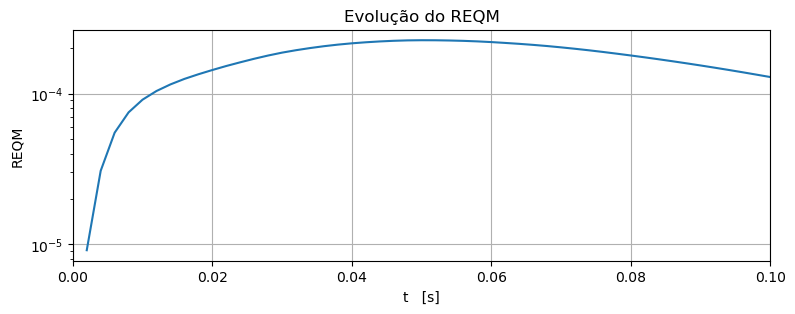

In [281]:
# plt.plot(error_list)
fig, axs = plt.subplots(1, 1, figsize = (9, 3))

plt.plot(Time[::2][1:], error_list[1:])
plt.xlim(left = 0.0, right = 0.1)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.yscale('log')
plt.title('Evolução do REQM')
plt.xlabel('t   [s]')
plt.ylabel('REQM')
plt.grid()

plt.show()

In [293]:
T_num_vec_reduced = []

for i in tqdm(np.arange(0, Nt, 2)):
    temp = []
    for k in np.arange(0, Ny, 2):
        for j in np.arange(0, Nx, 2):
            idx = j + Nx*k
            temp.append(T_num_vec[i, idx])

    T_num_vec_reduced.append(temp)

T_num_vec_reduced = np.array(T_num_vec_reduced)

100%|██████████| 51/51 [00:00<00:00, 1122.80it/s]


In [310]:
num_solution_ref = []

for i in tqdm(np.arange(0, 51, 1)):
    temp = []
    for k in np.arange(0, 51, 1):
        for j in np.arange(0, 51, 1):
            idx = j + Nx*k
            temp.append(num_solution[num_solution['idx_xy'] == idx][num_solution['idx_t'] == i]['f(x, y, t)'].sum())

    num_solution_ref.append(temp)

num_solution_ref = np.array(num_solution_ref)

  0%|          | 0/51 [00:00<?, ?it/s]/var/folders/xc/tffvs1z54w7bwv3cb731l0dc0000gn/T/ipykernel_2071/1530964809.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  temp.append(num_solution[num_solution['idx_xy'] == idx][num_solution['idx_t'] == i]['f(x, y, t)'].sum())
100%|██████████| 51/51 [00:43<00:00,  1.17it/s]


In [311]:
num_solution_ref.shape

(51, 2601)

In [312]:
num_error_vec = abs(num_solution_ref - T_num_vec_reduced)

In [313]:
Nx = 51
Ny = 51

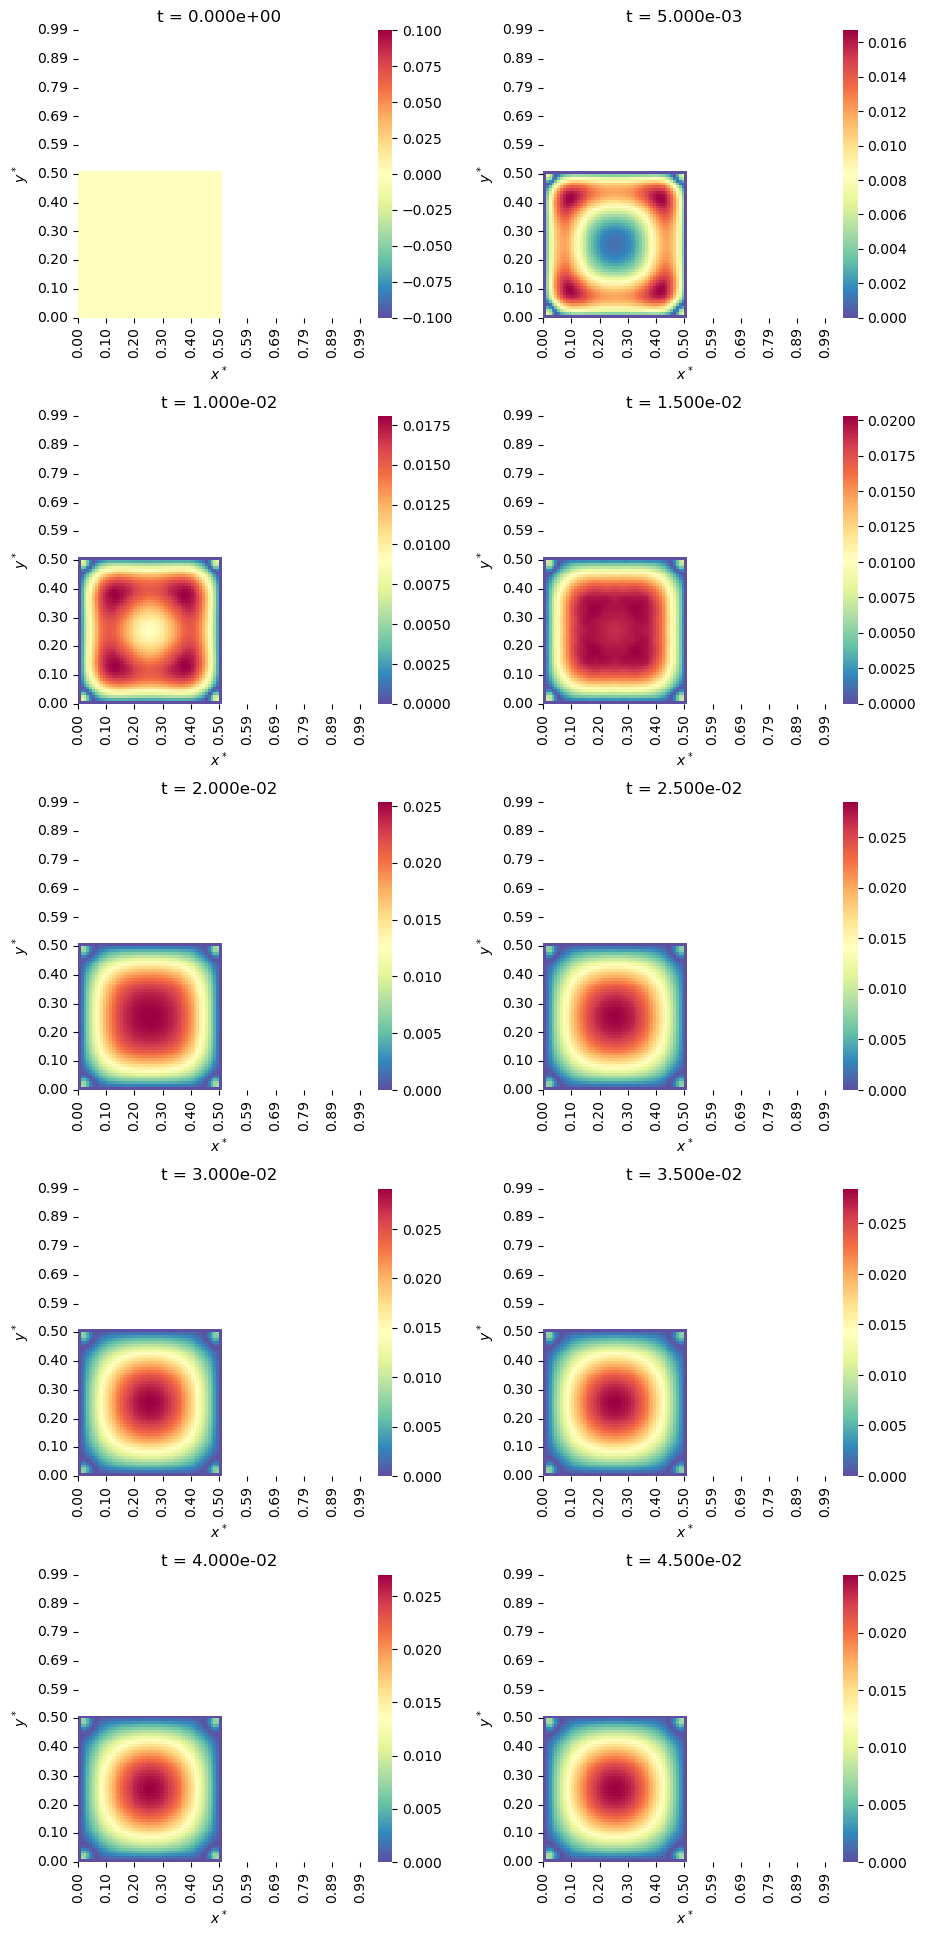

In [315]:
pplot(num_error_vec, N = 10, start = 0, step = 5, setLimits = [])

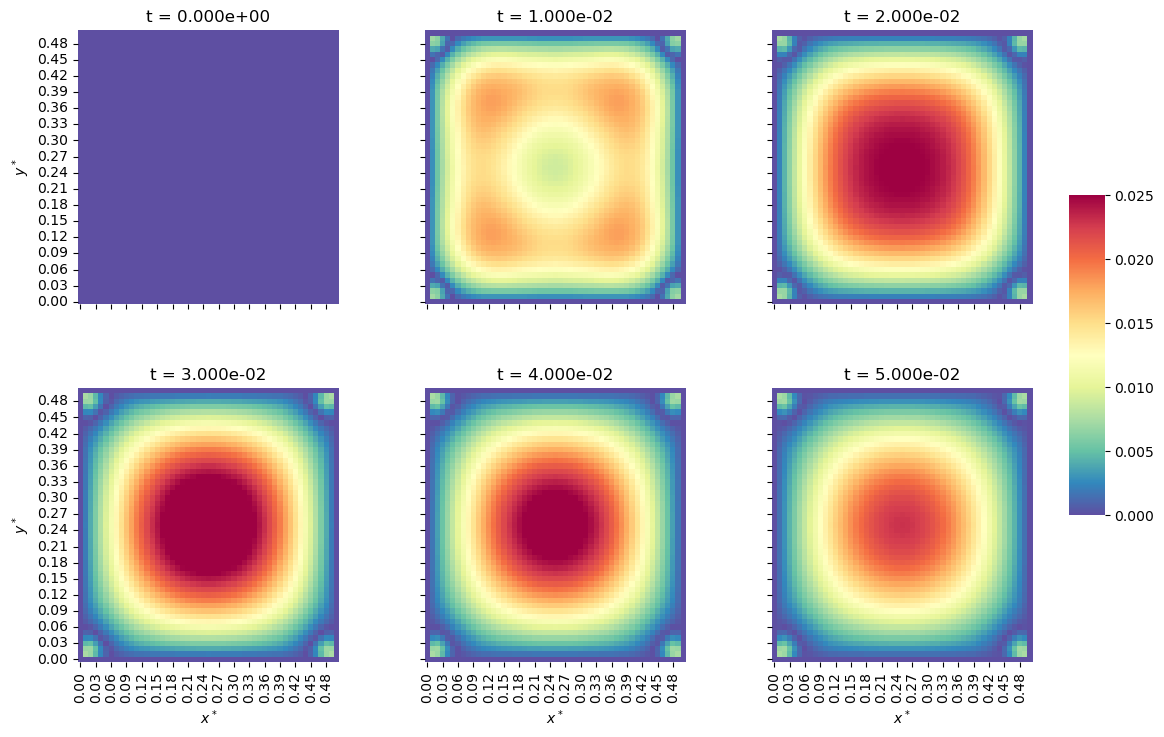

In [326]:
N = 6
start = 0
step = 10
setLimits = [0, 0.025]

nlines = N // 3
fig, axs = plt.subplots(nlines, 3, figsize = (12, 4*nlines), sharex = True, sharey = True)
fig.tight_layout(pad = 5)

num_ticks = 11
# number of points in x and y
nx = len(Xv)
ny = len(Yv)
# the index of the position of yticks
yticks = np.linspace(0, len(Yv) - 1, num_ticks)
xticks = np.linspace(0, len(Xv) - 1, num_ticks)

fmtx = lambda x, pos: '{:.2f}'.format(x*Lx/nx, pos)
fmty = lambda y, pos: '{:.2f}'.format(y*Ly/ny, pos)
    
cbar_ax = fig.add_axes([.91, .3, .03, .4])

# fig.tight_layout(pad = 5)
plt.subplots_adjust(right = 0.88)

for i in range(N):
    idxLine = i//3
    idxCol = i % 3

    idx = start + step*i

    T = np.reshape(num_error_vec[idx], (51, 51))
    
    if len(setLimits) == 0:
        minV = min(num_error_vec[idx])
        maxV = max(num_error_vec[idx])
    else:
        minV = setLimits[0]
        maxV = setLimits[1]


    sns.heatmap(
    T,
    ax = axs[idxLine, idxCol],
    cmap = "Spectral_r",
    vmin = minV,
    vmax = maxV,
    cbar_ax= cbar_ax
    )

    axs[idxLine, idxCol].invert_yaxis()
    # axs[idxLine, idxCol].set_xticks(xticks)
    # axs[idxLine, idxCol].set_yticks(yticks)

    if idxLine == nlines - 1: axs[idxLine, idxCol].set(xlabel = r'$x^*$')
    if idxCol  == 0: axs[idxLine, idxCol].set(ylabel = r'$y^*$')
    axs[idxLine, idxCol].set_title('t = %.3e' % ((idx)*dt))
    axs[idxLine, idxCol].xaxis.set_major_formatter(mlp.ticker.FuncFormatter(fmtx))
    axs[idxLine, idxCol].yaxis.set_major_formatter(mlp.ticker.FuncFormatter(fmty))

plt.show()